<a href="https://colab.research.google.com/github/lailahach/Classification-binaire-avec-un-r-seau-de-neurones/blob/main/TP11_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TF — Test Accuracy: 0.7414
TF — Test ROC-AUC: 0.8374

Classification report:
               precision    recall  f1-score   support

         0.0     0.7528    0.8933    0.8171        75
         1.0     0.7037    0.4634    0.5588        41

    accuracy                         0.7414       116
   macro avg     0.7283    0.6784    0.6879       116
weighted avg     0.7355    0.7414    0.7258       116



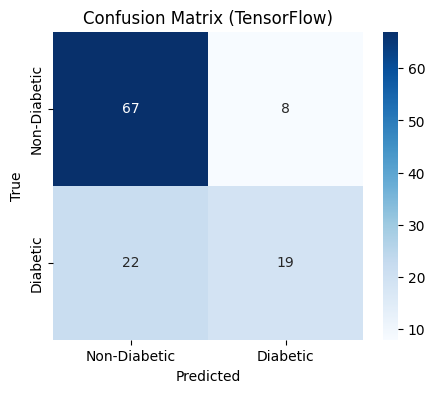

In [5]:
# train_pima_tf.py
import os, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import tensorflow as tf

# ---------- Reproductibilité ----------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ---------- 1) Chargement ----------
CSV_PATH = "/content/diabetes.csv"   # Kaggle Pima Indians
df = pd.read_csv(CSV_PATH)

# Colonnes
FEATURES = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin",
            "BMI","DiabetesPedigreeFunction","Age"]
TARGET   = "Outcome"

X = df[FEATURES].astype(np.float32).copy()
y = df[TARGET].astype(np.float32).values

# ---------- 2) Nettoyage : remplacer zéros invalides par médiane non nulle ----------
zero_invalid_cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for c in zero_invalid_cols:
    non_zero = X[c].replace(0, np.nan)
    med = np.nanmedian(non_zero)
    X.loc[X[c] == 0, c] = med

# ---------- 3) Normalisation (z-score) ----------
mu = X.mean(axis=0).values
sigma = X.std(axis=0).values
sigma[sigma == 0] = 1.0
X = (X.values - mu) / sigma

# ---------- 4) Split stratifié train/val/test ----------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

# ---------- 5) Hyperparamètres ----------
hidden_layers = [32, 16]  # paramétrable: modifiez la liste pour +/− de couches
lr = 0.01                 # SGD
batch_size = 32
epochs = 200

# ---------- 6) Modèle Keras ----------
inputs = tf.keras.Input(shape=(X.shape[1],))
x = inputs
for h in hidden_layers:
    x = tf.keras.layers.Dense(h, activation="relu",
                              kernel_initializer="he_normal")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs, name="PimaMLP_TF")

opt = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.0, nesterov=False)
model.compile(optimizer=opt,
              loss="binary_crossentropy",
              metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"),
                       tf.keras.metrics.AUC(name="auc")])

# ---------- 7) Entraînement ----------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max",
                                     patience=20, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0,
    callbacks=callbacks
)

# ---------- 8) Évaluation ----------
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(np.float32)
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("TF — Test Accuracy:", round(acc, 4))
print("TF — Test ROC-AUC:", round(auc, 4))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# Assertions utiles
assert model.input_shape == (None, 8)
assert model.output_shape == (None, 1)
assert np.all((y_prob >= 0.0) & (y_prob <= 1.0))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Prédictions sur test
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(np.int32)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Non-Diabetic", "Diabetic"],
            yticklabels=["Non-Diabetic", "Diabetic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (TensorFlow)")
plt.show()


Epoch 001 | val_acc=0.6522 val_auc=0.6517
Epoch 010 | val_acc=0.6522 val_auc=0.7630
Epoch 020 | val_acc=0.6522 val_auc=0.7820
Epoch 030 | val_acc=0.6522 val_auc=0.7880
Epoch 040 | val_acc=0.6696 val_auc=0.7933
Epoch 050 | val_acc=0.7217 val_auc=0.7953
Torch — Test Accuracy: 0.7414
Torch — Test ROC-AUC: 0.8237


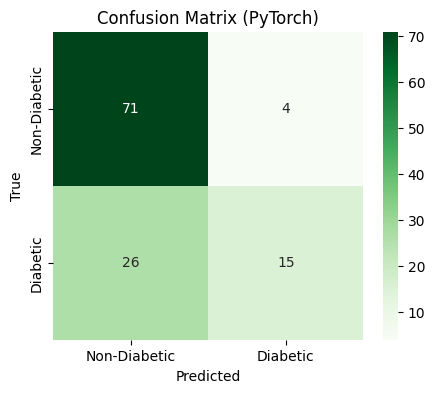

In [6]:
# train_pima_torch.py
import os, random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# ---------- Reproductibilité ----------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- 1) Chargement ----------
df = pd.read_csv(CSV_PATH)

FEATURES = ["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin",
            "BMI","DiabetesPedigreeFunction","Age"]
TARGET   = "Outcome"

X = df[FEATURES].astype(np.float32).copy()
y = df[TARGET].astype(np.float32).values

# ---------- 2) Nettoyage ----------
zero_invalid_cols = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]
for c in zero_invalid_cols:
    non_zero = X[c].replace(0, np.nan)
    med = np.nanmedian(non_zero)
    X.loc[X[c] == 0, c] = med

# ---------- 3) Normalisation ----------
mu = X.mean(axis=0).values
sigma = X.std(axis=0).values
sigma[sigma == 0] = 1.0
X = (X.values - mu) / sigma

# ---------- 4) Split stratifié ----------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=SEED, stratify=y_temp
)

# ---------- 5) Dataset / DataLoader ----------
class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X_train, y_train)
val_ds   = NumpyDataset(X_val, y_val)
test_ds  = NumpyDataset(X_test, y_test)

batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

# ---------- 6) MLP paramétrable ----------
def make_mlp(input_dim=8, hidden=[32,16], output_dim=1):
    layers = []
    in_dim = input_dim
    for h in hidden:
        layers += [nn.Linear(in_dim, h), nn.ReLU()]
        in_dim = h
    layers += [nn.Linear(in_dim, output_dim)]  # sortie logits
    return nn.Sequential(*layers)

hidden_layers = [32, 16]   # paramétrable
model = make_mlp(8, hidden_layers, 1).to(device)

# Assertions structure
with torch.no_grad():
    dummy = torch.zeros(1, 8).to(device)
    out = model(dummy)
    assert out.shape == (1, 1)

# ---------- 7) Perte + Optimiseur (SGD) ----------
criterion = nn.BCEWithLogitsLoss()         # combine sigmoïde + BCE de manière stable
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

# ---------- 8) Boucle d'entraînement ----------
epochs = 50
best_val_auc = -1.0
best_state = None

def evaluate(dataloader):
    model.eval()
    all_probs, all_targets = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            probs = torch.sigmoid(logits).cpu().numpy().ravel()
            all_probs.append(probs)
            all_targets.append(yb.cpu().numpy().ravel())
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)
    preds = (all_probs >= 0.5).astype(np.float32)
    acc = accuracy_score(all_targets, preds)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except ValueError:
        auc = np.nan
    return acc, auc

for epoch in range(1, epochs+1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    val_acc, val_auc = evaluate(val_dl)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | val_acc={val_acc:.4f} val_auc={val_auc:.4f}")

# ---------- 9) Évaluation test ------
if best_state is not None:
    model.load_state_dict(best_state)

test_acc, test_auc = evaluate(test_dl)
print("Torch — Test Accuracy:", round(test_acc, 4))
print("Torch — Test ROC-AUC:", round(test_auc, 4))

# Sanity checks
model.eval()
with torch.no_grad():
    probs = torch.sigmoid(model(torch.tensor(X_test[:8], dtype=torch.float32).to(device))).cpu().numpy()
    assert np.all((probs >= 0.0) & (probs <= 1.0))
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des probabilités
model.eval()
all_probs, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        all_probs.append(probs)
        all_targets.append(yb.cpu().numpy().ravel())

y_prob = np.concatenate(all_probs)
y_true = np.concatenate(all_targets)
y_pred = (y_prob >= 0.5).astype(np.int32)

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Non-Diabetic", "Diabetic"],
            yticklabels=["Non-Diabetic", "Diabetic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (PyTorch)")
plt.show()
